# Parent Classifier


In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
from tqdm.notebook import tqdm

# model_name = "nlpie/distil-biobert"
model_name = "nlpie/bio-distilbert-uncased"
# model_name = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Getting max token length

In [ ]:
# import matplotlib.pyplot as plt

# augmented_data = pd.read_csv("bms_data.csv")
# augmented_data = augmented_data.fillna("")
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# print(max([len(tokenizer.encode(row["Analysis"], row["Attribute"], truncation=False)) for _, row in augmented_data.iterrows()]))

### Preparing Dataset

In [2]:
augmented_data = pd.read_csv("augmented_labelled_data.csv")
augmented_data = augmented_data.fillna("")
augmented_data.shape

(45456, 3)

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoding = tokenizer(augmented_data["Analysis"].tolist(), augmented_data["Attribute"].tolist(), padding="max_length", truncation=True)
encoding.keys()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# Code to view tokens

# for idx, attr in augmented_data.iterrows():
#     augmented_data.at[idx, "Analysis_tokens"] = " ".join(tokenizer.tokenize(attr["Analysis"]))
#     augmented_data.at[idx, "Attribute_tokens"] = " ".join(tokenizer.tokenize(attr["Attribute"]))
# augmented_data[["Analysis", "Analysis_tokens", "Attribute", "Attribute_tokens", "Standard names"]]

In [4]:
class BMSDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


parent_label2id = {
  "ce-sds (non-reduced) hhl": 0,
  "ce-sds (non-reduced) purity": 0,
  "ce-sds (reduced) purity": 0,
  "sds-page (non-reduced) purity": 0,
  "sds-page (reduced) purity": 0,
  "ief acidic peaks": 1,
  "ief basic peaks": 1,
  "ief main peak": 1,
  "icief acidic peaks": 1,
  "icief basic peaks": 1,
  "icief main peak": 1,
  "cex acidic peaks": 1,
  "cex basic peaks": 1,
  "cex main peak": 1,
  "aex acidic peaks": 1,
  "aex basic peaks": 1,
  "aex main peak": 1,
  "rp-hplc purity": 2,
  "se-hplc hmw": 2,
  "se-hplc lmw": 2,
  "se-hplc monomer": 2,
  "se-uplc hmw": 2,
  "se-uplc lmw": 2,
  "se-uplc monomer": 2,
  "particulate-matter >= 10-um": 3,
  "particulate-matter >= 25-um": 3,
  "potency by cell-based bioassay": 4,
  "potency by binding elisa": 4,
  "spr binding activity": 4,
  "ph": 5,
  "protein concentration (a280)": 6,
  "polysorbate 80": 7
}

parent_labels = [parent_label2id[label.lower()] for label in augmented_data["Standard names"].tolist()]

bms_dataset = BMSDataset(encodings=encoding, labels=parent_labels)
parent_class_count = len(list(set(parent_label2id.values())))

### Model Training

In [5]:
parent_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=parent_class_count)
parent_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at nlpie/bio-distilbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=128,
    weight_decay=0.01,
    logging_dir='./logs',
    learning_rate=2e-5,
    seed=224,
    logging_strategy="epoch",
    logging_steps=1,
    fp16=True
)

trainer = Trainer(
    model=parent_model,
    args=training_args,
    train_dataset=bms_dataset
)
trainer.train()
parent_model.save_pretrained('./results')


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rohitvernekar (rohitvernekar-rutgers-university). Use `wandb login --relogin` to force relogin


Step,Training Loss
356,0.208600
712,0.006100
1068,0.002800
1424,0.001900
1780,0.001400


In [13]:
import gc

del parent_model
gc.collect()
torch.cuda.empty_cache()

### Testing model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

ana = "D_95007196"
attr = "PH"

test_str = tokenizer(ana, attr, padding="max_length", truncation=True, return_tensors="pt")

trained_model = AutoModelForSequenceClassification.from_pretrained('./results')
trained_model.eval()
test_str
res = trained_model(**test_str)
res = torch.softmax(res.logits, dim=1)
print(torch.max(res).item())
print(res)

print(int(res.argmax()))

0.9999269247055054
tensor([[8.3542e-06, 8.5003e-06, 7.7285e-06, 9.9000e-06, 5.4789e-06, 9.9993e-01,
         1.2268e-05, 1.4775e-05, 6.0598e-06]], grad_fn=<SoftmaxBackward0>)
5


### Getting Predictions


In [ ]:
bms_data = pd.read_csv("bms_data.csv")
bms_data = bms_data.fillna("")
bms_data.shape

(7730, 2)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
bms_encodings = tokenizer(bms_data["Analysis"].tolist(), bms_data["Attribute"].tolist(), max_length=512, padding="max_length", truncation=True)
bms_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
class BMSTest(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        enc = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        return enc

    def __len__(self):
        return len(self.encodings["input_ids"])

bms_test_dataset = BMSTest(bms_encodings)
bms_test_dataloader = DataLoader(bms_test_dataset, batch_size=64)

In [ ]:
trained_model = AutoModelForSequenceClassification.from_pretrained('./results')
trained_model.to(device)
trained_model.eval()

parent_class_list, parent_class_prob_list = [], []

with torch.no_grad():
    for enc in tqdm(bms_test_dataloader):
        outputs = trained_model(**enc)

        parent_class_prob, parent_class = torch.max(torch.softmax(outputs.logits, dim=1), dim=1)

        parent_class_list.extend(parent_class.cpu().numpy())
        parent_class_prob_list.extend(parent_class_prob.cpu().numpy())


  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
bms_data["parent_class"] = parent_class_list
bms_data["parent_class_prob"] = parent_class_prob_list
bms_data.head()

,Analysis,Attribute,parent_class,parent_class_prob
0,D_250475,IL2 INHIBITION ASSAY,4,0.997881
1,D_95007196,PH,5,0.998068
2,D_M00003744,ABATACEPT MAJOR BAND (REDUCED),0,0.939688
3,Y_SM_95011468_R,BIOASSAY,4,0.997338
4,250684_CE_SDS_REDUC,SUM HEAVY AND LIGHT CHAIN,0,0.999499


In [ ]:
bms_data.to_csv("processed_data.csv")

### Visualization

   Unnamed: 0             Analysis                       Attribute   P-Value  \
0           0             D_250475            IL2 INHIBITION ASSAY  0.907133   
1           1           D_95007196                              PH  0.849765   
2           2          D_M00003744  ABATACEPT MAJOR BAND (REDUCED)  0.851597   
3           3      Y_SM_95011468_R                        BIOASSAY  0.984260   
4           4  250684_CE_SDS_REDUC       SUM HEAVY AND LIGHT CHAIN  0.998909   

   Label  
0    7.0  
1    8.0  
2    2.0  
3    5.0  
4    0.0  


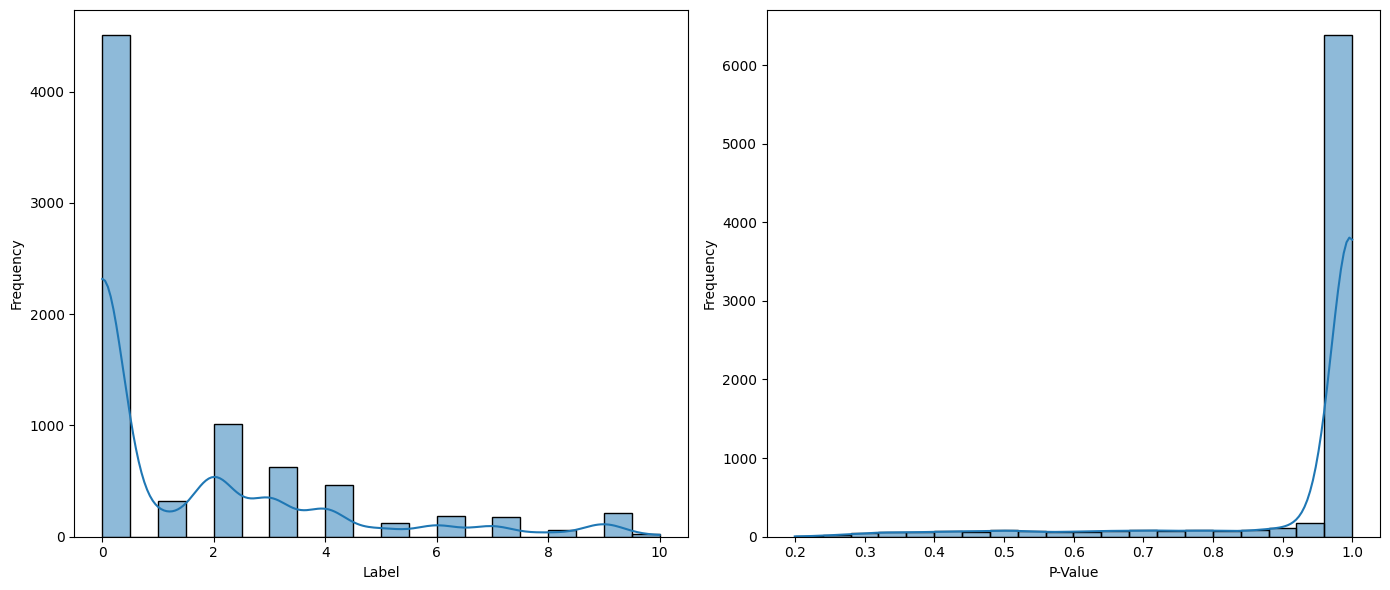

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed_data.csv")


print(df.head())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['Label'], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Frequency')


sns.histplot(df['P-Value'], bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel('P-Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
